# Flood prediction: EDA which makes sense

This notebook is the start of an EDA for the flood prediction competition. It shows:
- a preliminary analysis of the data
- how to cross-validate
- some baseline models
- how to get an r2 score of 0.844 with a one-liner
- how to engineer features for better scores

Reference: [Regression with a Flood Prediction Dataset](https://www.kaggle.com/competitions/playground-series-s4e5/)

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

from IPython.display import display
from matplotlib.ticker import MaxNLocator
from scipy.stats import poisson

# from matplotlib.ticker import MaxNLocator
# import seaborn as sns
# from colorama import Fore, Style
# import xgboost
# import lightgbm
# import catboost
# import os
# import datetime
# import pickle
# import warnings
# import umap
# import statsmodels.api as sm

# from sklearn.base import clone
# from sklearn.model_selection import KFold, StratifiedKFold 
# from sklearn.pipeline import make_pipeline, Pipeline
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer, OneHotEncoder
# from sklearn.kernel_approximation import Nystroem
# from sklearn.linear_model import Ridge, LinearRegression
# from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
# from sklearn.metrics import r2_score
# from sklearn.manifold import TSNE

In [2]:
COMPUTE_TEST_PRED:bool = True

oof: dict = {}
test_pred: dict = {}

# Reading the data

We read the data and see that the training dataset has over a million rows and twenty features.

Insight:
1. We'll need algorithms which can handle that much data (i.e., no nearest neighbors, no kernel matrices).
2. Maybe for that much data we'll not always do a five-fold cross-validation. If we do only a simple train–test split, we can save a lot of time.


In [3]:
train: pd.DataFrame = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id')
test: pd.DataFrame = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

init_feats: list[str] = list(test.columns)
display(train.head())

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


# Target distribution

The target ranges from 0.285 to 0.725. There are only 83 unique targets (FloodProbability). All targets are multiples of 0.005.

We plot a histogram with bins of width 0.005 so that every possible target value falls into its own bin. The histogram is symmetric and resembles a normal distribution with mean at 0.5.

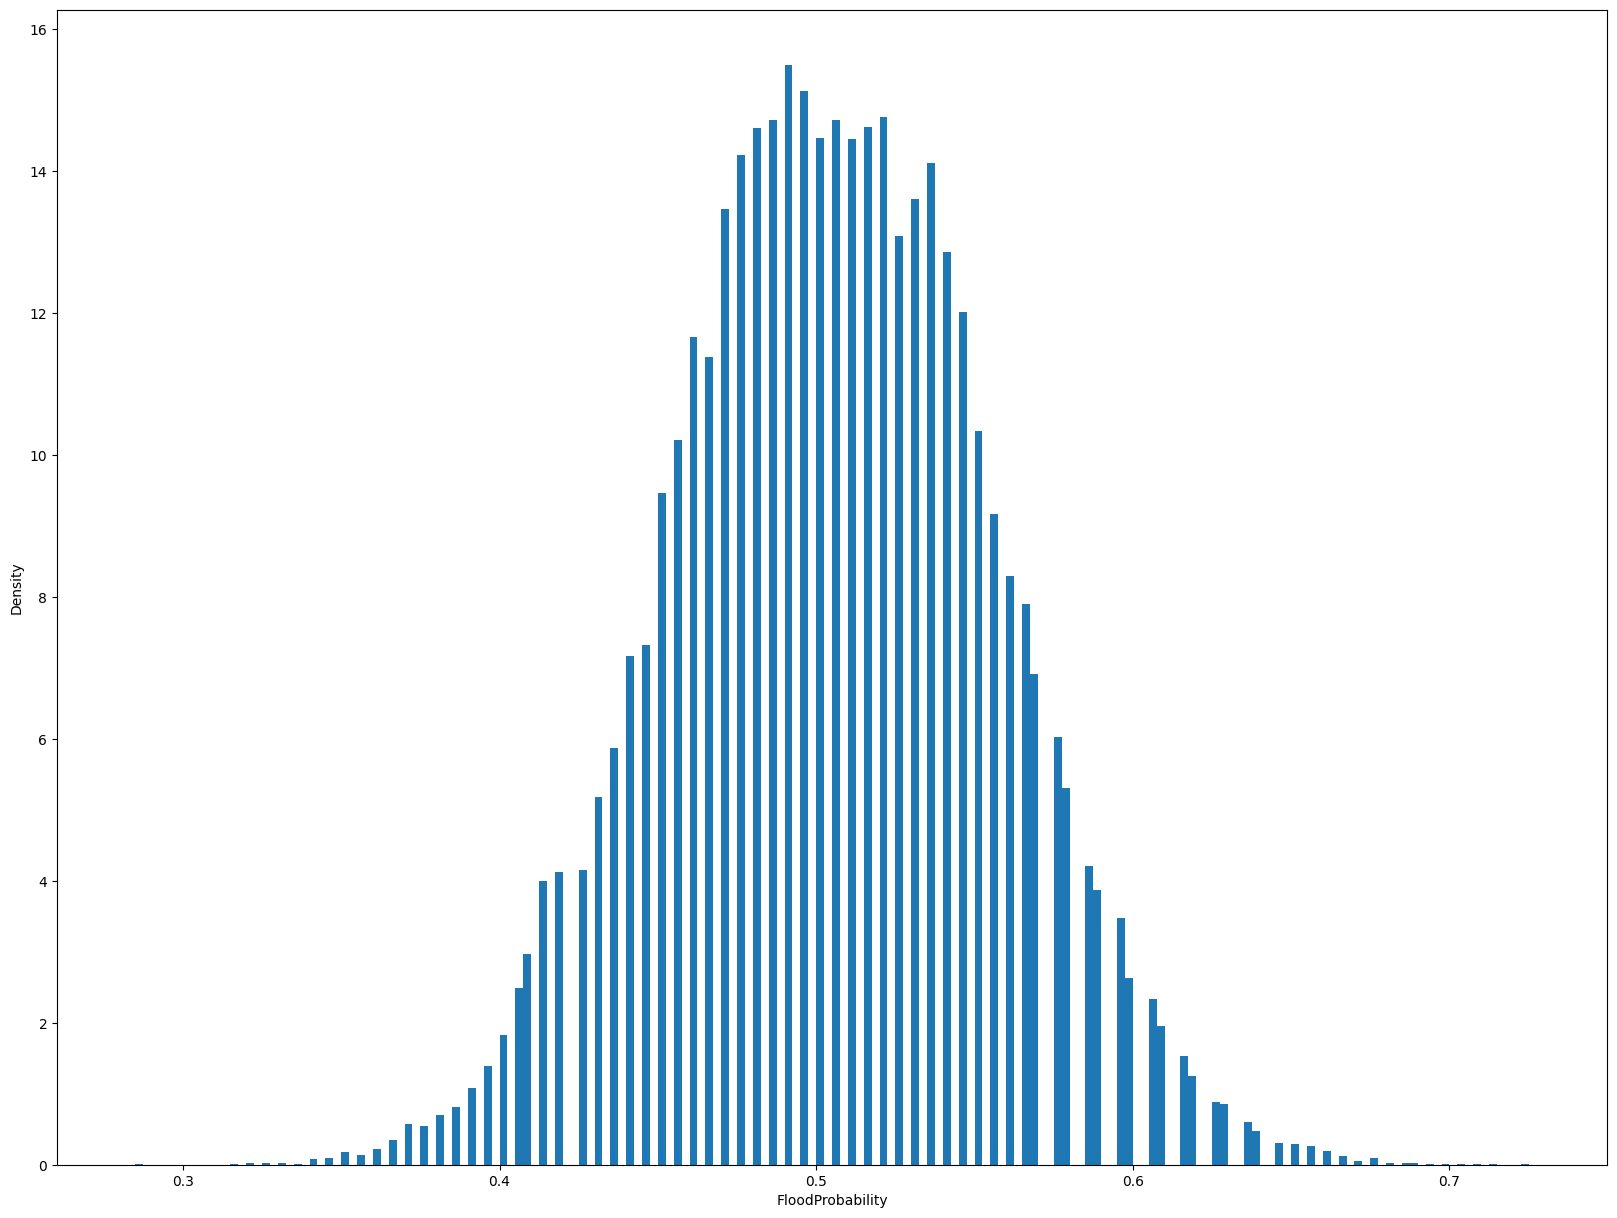

In [6]:
plt.figure(figsize=(20, 15))

plt.hist(train.FloodProbability, bins=np.linspace(0.2825, 0.7275, 179), density=True)
plt.ylabel('Density')
plt.xlabel('FloodProbability')

plt.show()

# Feature distributions

All features are integers and have right-skewed distributions. Train and test distributions are indistinguishable in the histograms. (You'd see blue and orange bars if the distributions differed.)

According to @vlada, the [distributions are Poisson distributions](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499244).

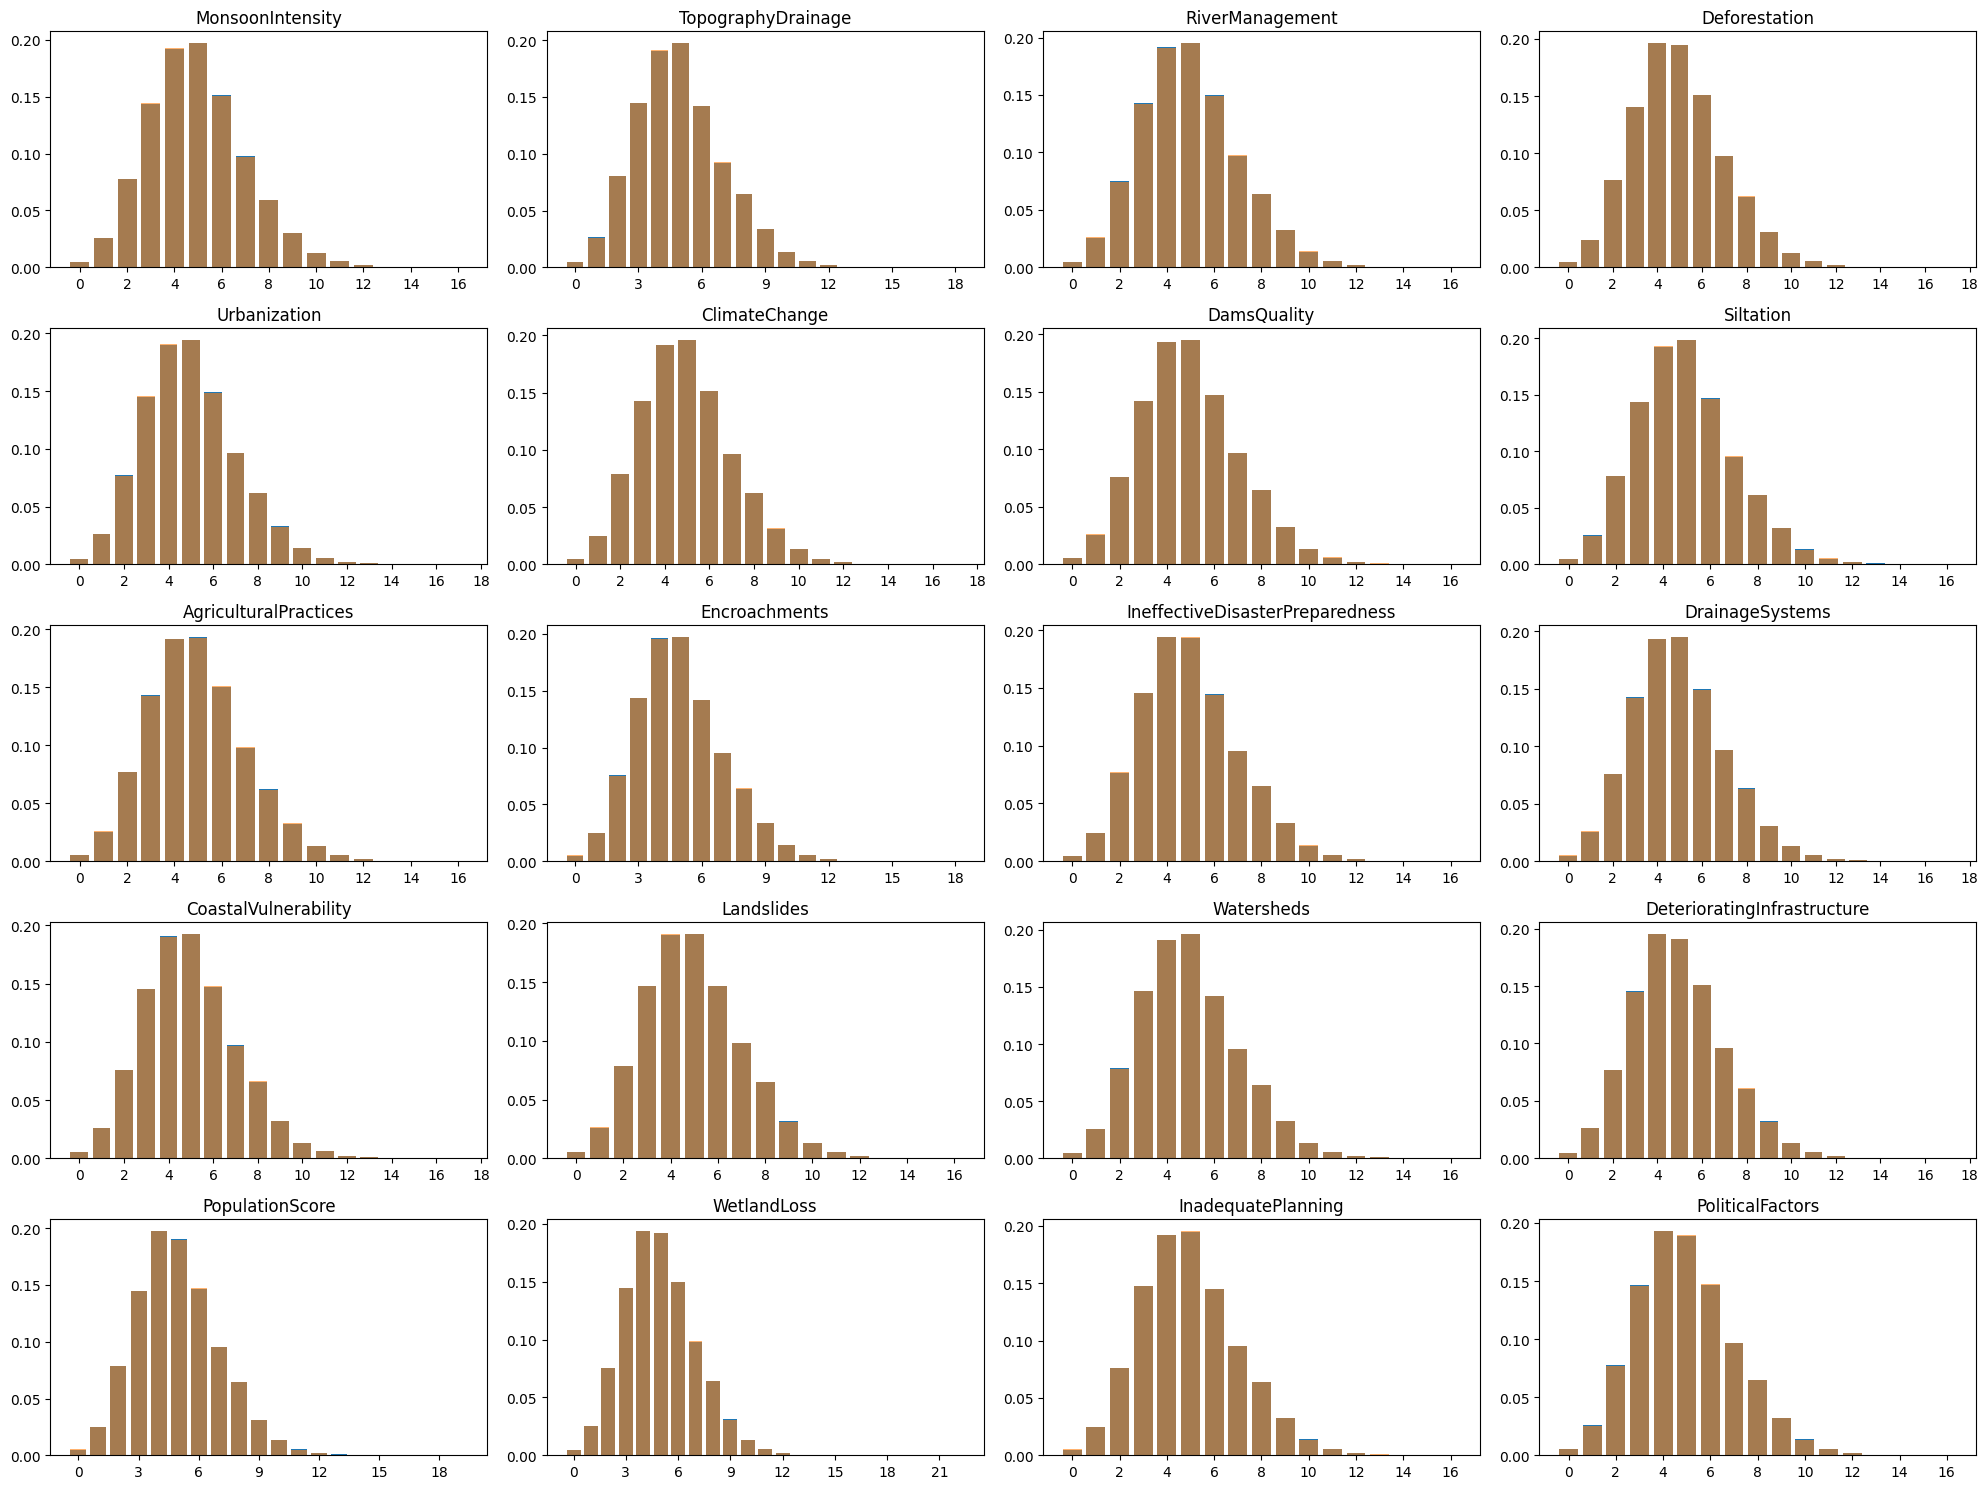

In [12]:
fig, axs = plt.subplots(5, 4, figsize=(20, 15))

for col, ax in zip(init_feats, axs.ravel()):
    vc = train[col].value_counts() / len(train)
    ax.bar(vc.index, vc)
    
    vc = test[col].value_counts() / len(test)
    ax.bar(vc.index, vc, alpha=0.6)
    
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels

plt.tight_layout()
plt.show()

In [56]:
def does_follow_poisson(col: pd.Series, conf_lvl: float = 0.95) -> bool:
    arr: np.ndarray = col.astype(float).to_numpy()
    mean: int = np.mean(arr)

    _, p_value = st.kstest(arr, poisson.rvs(mu=mean, size=len(col)))
    return p_value < (1 - conf_lvl)

# Assuming 'train' is your DataFrame
for col in train.columns:
    is_poisson: bool = does_follow_poisson(train[col])
    if is_poisson:
        print(f'{col} follows a Poisson distribution.')
    else:
        print(f'{col} does not follow a Poisson distribution.')

SyntaxError: invalid syntax (2571926784.py, line 5)

# Correlations

The correlation matrix shows that there is no correlation among the features, but all features are correlated with the target.

Wait, there is more to discover! None of the gray entries of the correlation heatmap is marked with 0.0; all of them are -0.0. There is no exception. This means that any pair of two features is negatively correlated. The features are statistically dependent.

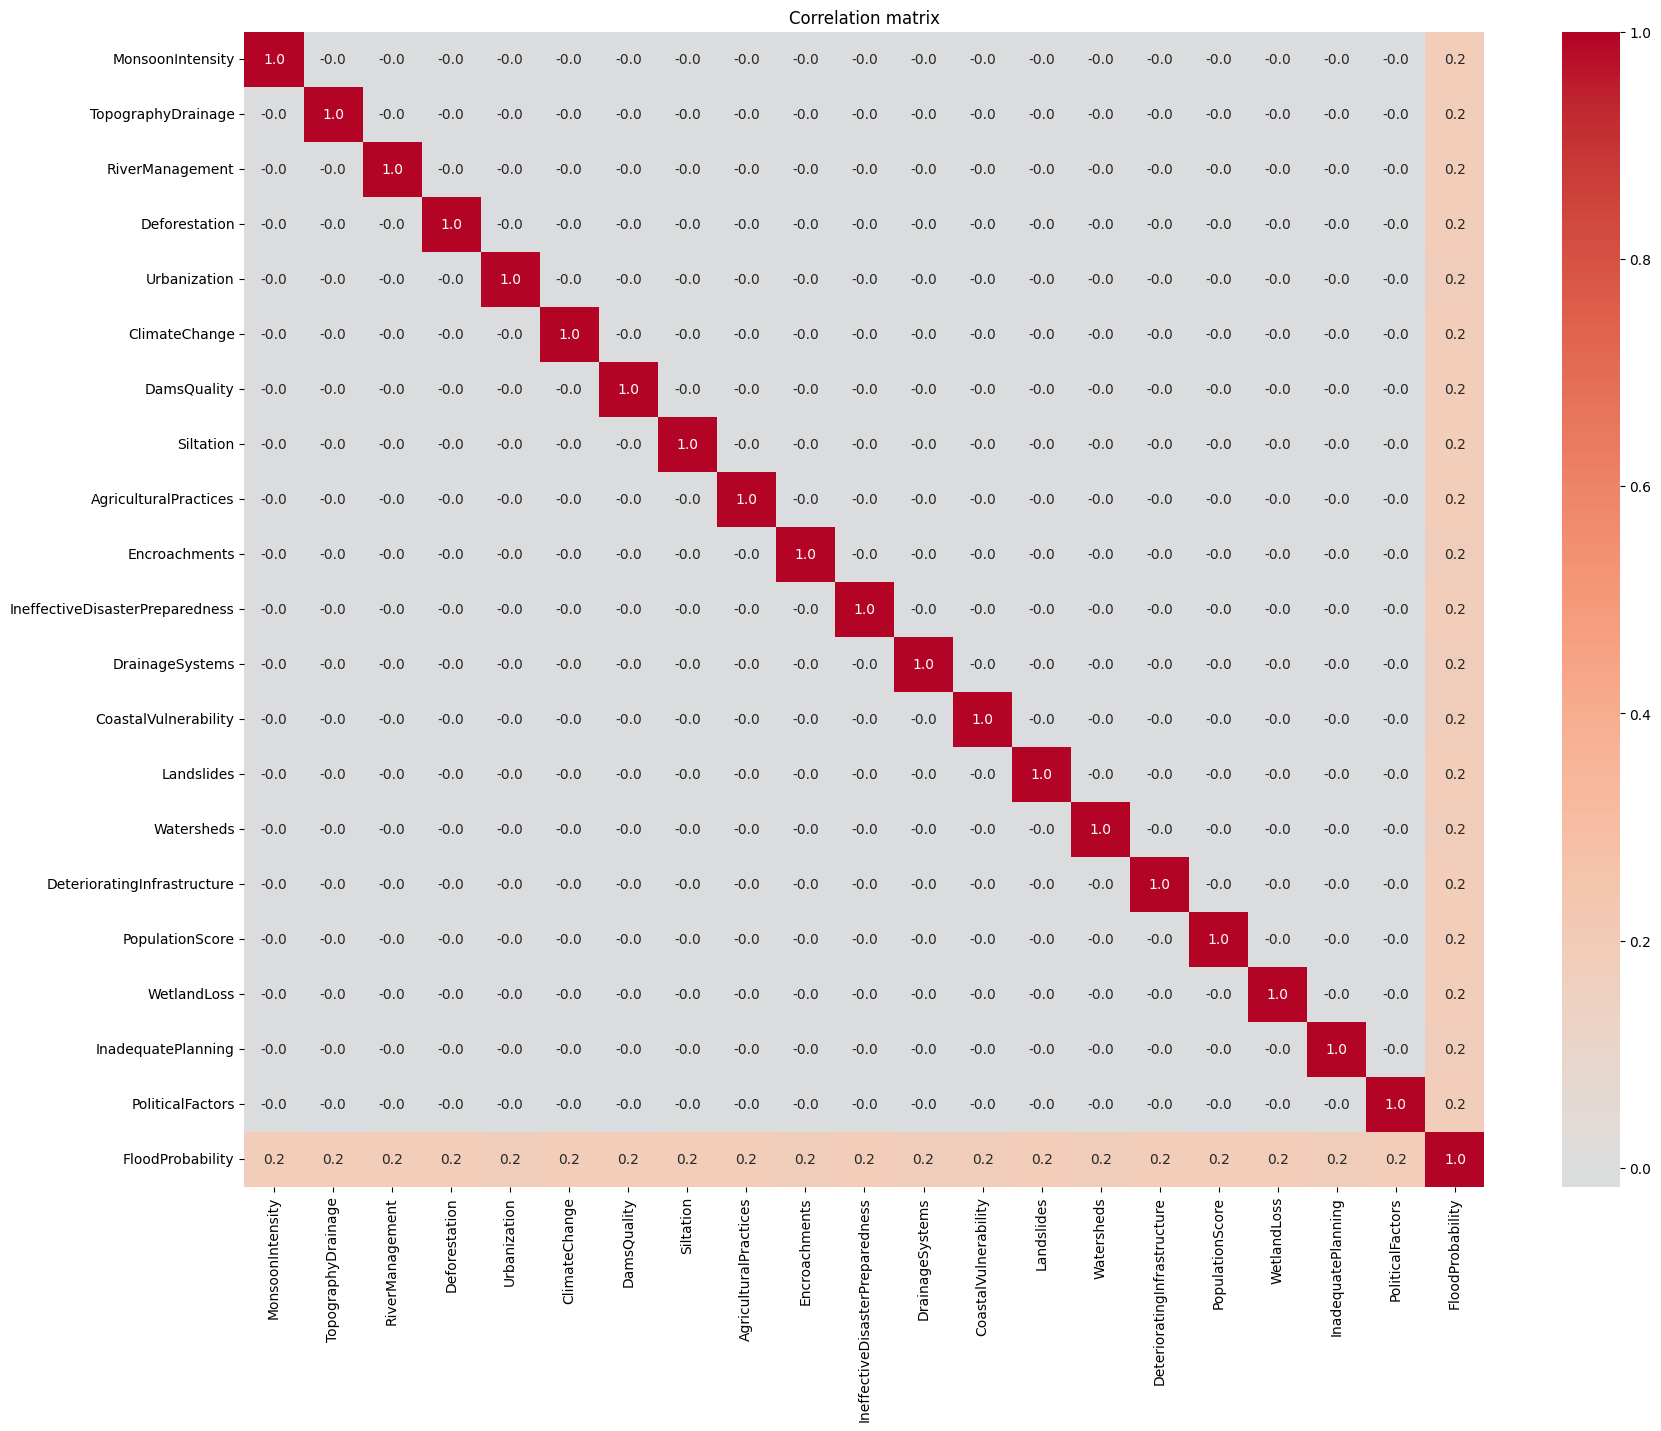

In [61]:
corr_feats = init_feats + ['FloodProbability']
cc = np.corrcoef(train[corr_feats], rowvar=False)

plt.figure(figsize=(20, 15))

sns.heatmap(cc, center=0, cmap='coolwarm', annot=True, fmt='.1f', xticklabels=corr_feats, yticklabels=corr_feats)
plt.title('Correlation matrix')

plt.show()

# Dimensionality reduction: PCA, UMAP or t-SNE?

## PCA

A principal component analysis (PCA) indicates that the dataset is full-dimensional. Linear dimensionality reduction would be pointless.

In [ ]:
pca = PCA()
pca.fit(train[initial_features])
plt.figure(figsize=(3, 2.5))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.title('Principal Components Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.yticks([0, 1])
plt.show()

## UMAP

Unsupervised [UMAP](https://umap-learn.readthedocs.io/) projects the dataset to two dimensions and sometimes gives additional insight. This time it doesn't.

In [ ]:
%%time
# Unsupervised UMAP

def plot_embedding(embedding, target, title):
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=target,
        cmap='coolwarm'
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=18)
    plt.show()

train_sample = train.sample(10000)
reducer = umap.UMAP()
plot_embedding(reducer.fit_transform(train_sample[initial_features]),
               train_sample.FloodProbability,
               'Unsupervised UMAP projection of the training dataset')

We can as well run a supervised version of UMAP. It gives a nice diagram, but the diagram only shows that the target has 83 unique values. Again no useful result.

In [ ]:
%%time
# Supervised UMAP with regression target
train_sample = train.sample(100000)
reducer = umap.UMAP(n_neighbors=100, target_metric='manhattan',
                    target_weight=0.6, min_dist=1)
plot_embedding(reducer.fit_transform(train_sample[initial_features],
                                     y=train_sample.FloodProbability),
               train_sample.FloodProbability,
               'Supervised UMAP projection of the training dataset')

## t-SNE

t-SNE isn't any better:

In [ ]:
%%time
# t-SNE
train_sample = train.sample(20000)
reducer = TSNE()
plot_embedding(reducer.fit_transform(train_sample[initial_features]),
               train_sample.FloodProbability,
               '(Unsupervised) t-SNE projection of the training dataset')


# Cross-validation

To ensure that our cross-validation results are consistent, we'll use the same function for cross-validating all models.

For now, we evaluate only the first fold to save time. If later in the process we need higher-precision cv scores, we can re-run the notebook with all five folds.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

SINGLE_FOLD = True

def cross_validate(model, label, features=initial_features, n_repeats=1):
    """Compute out-of-fold and test predictions for a given model.
    
    Out-of-fold and test predictions are stored in the global variables
    oof and test_pred, respectively.
    
    If n_repeats > 1, the model is trained several times with different seeds.
    """
    start_time = datetime.datetime.now()
    scores = []
    oof_preds = np.full_like(train.FloodProbability, np.nan, dtype=float)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        y_tr = train.iloc[idx_tr].FloodProbability
        y_va = train.iloc[idx_va].FloodProbability
        
        y_pred = np.zeros_like(y_va, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(X_va)
        y_pred /= n_repeats
        
#         residuals = y_va - y_pred
#         plt.figure(figsize=(6, 2))
#         plt.scatter(y_pred, residuals, s=1)
#         plt.axhline(0, color='k')
#         plt.show()
        
        score = r2_score(y_va, y_pred)
        print(f"# Fold {fold}: R2={score:.5f}")
        scores.append(score)
        oof_preds[idx_va] = y_pred
        if SINGLE_FOLD: break
            
    elapsed_time = datetime.datetime.now() - start_time
    print(f"{Fore.GREEN}# Overall: {np.array(scores).mean():.5f} {label}"
          f"{' single fold' if SINGLE_FOLD else ''}"
          f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    oof[label] = oof_preds
    
    if COMPUTE_TEST_PRED:
        # Retrain n_repeats times with the whole dataset and average
        y_pred = np.zeros(len(test), dtype=float)
        X_tr = train[features]
        y_tr = train.FloodProbability
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(test[features])
        y_pred /= n_repeats
        test_pred[label] = y_pred

# Linear models

We start with linear regression models with various feature transformations. `PolynomialFeatures` gives a slight score improvement, but not much.

In [ ]:
model = make_pipeline(StandardScaler(),
                      LinearRegression())
cross_validate(model, 'LinearRegression')

model = make_pipeline(StandardScaler(),
                      PolynomialFeatures(degree=2),
                      Ridge())
cross_validate(model, 'Poly-Ridge')

model = make_pipeline(StandardScaler(),
                      SplineTransformer(),
                      Ridge())
cross_validate(model, 'Spline-Ridge')

As an alternative to scikit-learn's `LinearRegression`, we can use the statsmodels implementation. It shows us the regression coefficients with their pvalues:

In [ ]:
import statsmodels.api as sm
X = sm.add_constant(train[initial_features])
res = sm.OLS(train.FloodProbability, X, missing='error').fit()
res.summary()

All features basically have the same coefficient of 0.0056. We can explain the model in prose:

> **Take the sum of all features, multiply by 0.0056, subtract 0.05, and you'll get the flood probability.**

We can implement this in a one-liner and get an r2 score of 0.844:

In [ ]:
r2_score(train.FloodProbability, (train[initial_features].sum(axis=1) * 0.0056) - 0.05)

When I plotted the histogram of the target values above, I wrote that the histogram looks like a normal distribution. We now have the explanation: If you add twenty independent random variables, it's normal that you get a normal distribution (pun intended).

In [ ]:
# # Nystroem transformer + Ridge
# model = make_pipeline(StandardScaler(),
#                       Nystroem(n_components=600),
#                       Ridge())
# cross_validate(model, 'Nystroem-Ridge')
# # Overall: 0.76973 Nystroem-Ridge   0 min 100 components
# # Overall: 0.78258 Nystroem-Ridge   1 min 200 components
# # Overall: 0.78764 Nystroem-Ridge   1 min 300 components
# # Overall: 0.79753 Nystroem-Ridge   2 min 600 components

# Tree-based models

With the given 20 features, ExtraTrees isn't competitive.

In [ ]:
# # ExtraTreesRegressor
# model = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=1)
# cross_validate(model, 'ET')
# # Overall: 0.66575 ET single fold   9 min

The following XGBoost model is inferior to linear regression, but could get better with more hyperparameter tuning (or simply with more iterations).

In [ ]:
# XGBoost
xgb_params = {'grow_policy': 'depthwise', 'n_estimators': 100, 'learning_rate': 0.2639887908316703, 'max_depth': 10, 'reg_lambda': 62.46661785864016, 'min_child_weight': 0.33652299514909034, 'colsample_bytree': 0.2319730052165745, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'max_bin': 2048, 'gamma': 0} # 0.83868
model = xgboost.XGBRegressor(**xgb_params)
cross_validate(model, 'XGBoost')
# Overall: 0.83949 XGB single fold   0 min

Surprisingly enough, CatBoost performs well without any tuning:

In [ ]:
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost')
# Overall: 0.84722 CB single fold   1 min

In [ ]:
model = lightgbm.LGBMRegressor(verbose=-1)
cross_validate(model, 'LightGBM')

# Advanced models with feature engineering

Above, we have seen that a one-liner model can start with the sum of all features. If we plot the sum of all features against the target, we see that sums 72, 73, 74 and 75 are special and lead to a higher flood probability:

In [ ]:
temp = train.FloodProbability.groupby(train[initial_features].sum(axis=1)).mean()
plt.scatter(temp.index, temp, s=1, c=(temp.index.isin(np.arange(72, 76))), cmap='coolwarm')
plt.xlabel('sum of twenty initial features')
plt.ylabel('mean flood probability')
plt.show()

It becomes obvious that we have to add new features to the dataset:

In [ ]:
# Add the special1 and fsum features
for df in [train, test]:
    df['fsum'] = df[initial_features].sum(axis=1) # for tree models
    df['special1'] = df['fsum'].isin(np.arange(72, 76)) # for linear models

We re-fit three models with the added feature and see a substantial improvement:
1. Linear regression with the twenty initial features and the new feature `special1`
2. Ridge regression with only the one-hot-encoded `fsum`
3. Untuned CatBoost

In [ ]:
model = make_pipeline(StandardScaler(),
                      LinearRegression())
cross_validate(model, 'LinearRegression special1', features=initial_features+['special1'])
# Overall: 0.85218 LinearRegression special single fold   0 min

In [ ]:
model = make_pipeline(OneHotEncoder(categories=[np.unique(train.fsum)],
                                    drop='first', sparse_output=False),
                      StandardScaler(),
                      Ridge())
cross_validate(model, 'Ridge one-hot fsum', features=['fsum'])

In [ ]:
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost fsum', features=initial_features+['fsum'])
# Overall: 0.86840 CatBoost single fold   2 min

@siukeitin proposed to [sort along the feature axis as "feature engineering"](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499579). Let's do this and fit an untuned CatBoost to the new features. The score increases again:

In [ ]:
sorted_features = [f"sort_{i}" for i in np.arange(len(initial_features))]
for df in [train, test]:
    df[sorted_features] = np.sort(df[initial_features], axis=1)
train

In [ ]:
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost sorted', features=sorted_features+['fsum'])


`ExtraTreesRegressor` is slower than CatBoost and has a somewhat lower score. Note that for `ExtraTreesRegressor` you always need to tune the `min_samples_leaf` hyperparameter:

In [ ]:
# ExtraTreesRegressor
model = ExtraTreesRegressor(min_samples_leaf=100)
cross_validate(model, f'ExtraTrees', features=['fsum']+sorted_features)


Even ridge regression with one-hot encoded features has a good score:

In [ ]:
model = make_pipeline(OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
                      StandardScaler(),
                      Ridge())
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    cross_validate(model, 'Ridge one-hot', features=initial_features+sorted_features+['fsum'])

Other people have proposed to add rowwise median, std, quantiles and more to the dataset:

In [ ]:
extra_features = ['fmedian', 'fstd']
for df in [train, test]:
    df['fmedian'] = np.median(df[initial_features], axis=1)
    df['fstd'] = np.std(df[initial_features], axis=1)
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost extra', features=sorted_features+['fsum']+extra_features)


# Evaluation

For the time being, CatBoost with the added features wins.

In [ ]:
result_list = []
for label in oof.keys():
    mask = np.isfinite(oof[label])
    score = r2_score(train.FloodProbability[mask], oof[label][mask])
    result_list.append((label, score))
result_df = pd.DataFrame(result_list, columns=['label', 'score'])
result_df.sort_values('score', inplace=True, ascending=False)

plt.figure(figsize=(12, len(result_df) * 0.4 + 0.4))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color='lightgreen')
plt.annotate('Best model without feature engineering', 
             (0.850, list(result_df.label).index('CatBoost')),
             xytext=(0.855, list(result_df.label).index('CatBoost')+2),
             arrowprops={'width': 2, 'color': 'darkgreen'},
             color='darkgreen')
plt.gca().bar_label(bars, fmt='%.5f')
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.gca().invert_yaxis()
plt.xlim(0.835, 0.875)
plt.xlabel(f'{"fold 0" if SINGLE_FOLD else "5-fold cv"} r2 score (higher is better)')
plt.show()

# Submission

In [ ]:
if COMPUTE_TEST_PRED:
    print(result_df.label.iloc[0])
    sub = pd.Series(test_pred[result_df.label.iloc[0]], index=test.index, name='FloodProbability')
    filename = 'submission.csv'
    sub.to_csv(filename)
    os.system(f"head {filename}")

# Conclusion

1. We have some baseline models. 
2. We have seen that feature engineering is key in this competition. More feature engineering is needed!

# Exercises

1. Invent more features and evaluate their usefulness.
2. Tune CatBoost, LightGBM and XGBoost for the highest score.
3. Ensemble several models.
